# RNNs para Martín Fierro

El objetivo de los ejercicios en este tutorial es mostrar el impacto de algunas decisiones de diseño en la implementación de las redes neuronales, particularmente las recurrentes. Como ejemplo veremos una implementación de la red RNN para generación de lenguaje basada en caracteres de [Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Para entrenarla utilizaremos un fragmento del Martín Fierro que pueden descargar [aquí](https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/martin_fierro.txt). Para un entrenamiento más complejo, pueden utilizar las obras completas de borges, disponibles en [este link](https://drive.google.com/file/d/0B4remi0ZCiqbUFpTS19pSmVFYkU/view?usp=sharing).


In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import random
import re
import sys
import os
import wget
import unicodedata

Primero leeremos el dataset del archivo de texto y lo preprocesaremos para disminuir la viariación de caracteres. Normalizaremos el formato unicos, elminaremos espacios y transformaremos todo a minúsculas.

In [19]:
if not os.path.exists('martin_fierro.txt'):
    wget.download('https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/martin_fierro.txt')

In [20]:
with open('./martin_fierro.txt', 'r') as finput:
    text = unicodedata.normalize('NFC', finput.read()).lower()
    text = re.sub('\s+', ' ', text).strip()

print('Corpus length: %d' % len(text))

Corpus length: 33858


Luego, contaremos la cantidad de caracteres únicos presentes en el texto, y le asignaremos a cada uno un índice único y secuencial. Este índice será utilizado luego para crear las representaciones one-hot encoding de los caracteres.

In [4]:
chars = sorted(list(set(text)))

print('Total chars: %d' % len(chars))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Total chars: 54


## Parte 1: Esqueleto de la red neuronal

Lo primero que debemos pensar es cómo será la arquitectura de nuestra red para resolver la tarea deseada. En esta sección crearemos el modelo sequencial con PyTorch que representará nuestra red. En los pasos siguientes, implementaremos las transformaciones del corpus, por lo que en este paso pueden asumir cualquier formato en los datos de entrada.

Para poder implementar el modelo debemos responder las siguientes preguntas:
  - ¿Es una red one-to-one, one-to-many, many-to-one o many-to-many?
  - ¿Cuál es el formato de entrada y de salida de la red? ¿Cuál es el tamaño de las matrices (tensores) de entrada y de salida?
  - Luego de que la entrada pasa por la capa recurrente, ¿qué tamaño tiene el tensor?
  - ¿Cómo se conecta la salida de la capa recurrente con la capa densa que realiza la clasificación?
  - ¿Cuál es el loss apropiado para este problema?

Primero importamos los módulos que necesitaremos para implementar nuestra red:
  - torch: acceso a todo el framework
  - torch.nn: nos da acceso a capas ya implementadas y a la clase Module para instanciar y crear nuestra red
  

In [5]:
import torch
import torch.nn as nn

# Checkeamos si estamos corriendo con una GPU
use_cuda = torch.cuda.is_available()

In [6]:
class MyModel(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_layer,
                 num_layers=1, dropout=0., bias=True,
                 bidirectional=False):
        
        super(MyModel, self).__init__()
        
        # Set our LSTM parameters
        self.lstm_config = {'input_size': input_size,
                            'hidden_size': hidden_layer,
                            'num_layers': num_layers,
                            'bias': bias,
                            'batch_first': True,
                            'dropout': dropout,
                            'bidirectional': bidirectional}
        
        # Set our FC layer parameters
        self.linear_config = {'in_features': hidden_layer,
                              'out_features': vocab_size,
                              'bias': bias}
        
        # Instanciate the layers
        self.encoder = nn.LSTM(**self.lstm_config)
        self.decoder = nn.Sequential()
        self.decoder.add_module('linear', nn.Linear(**self.linear_config))
        self.decoder.add_module('softmax',nn.LogSoftmax(dim=-1))

    def forward(self, inputs):
        outputs, _ = self.encoder(inputs)
        predictions = self.decoder(outputs)
        return predictions

In [7]:
model = MyModel(len(chars), len(chars), 128)
print(model)

MyModel(
  (encoder): LSTM(54, 128, batch_first=True)
  (decoder): Sequential(
    (linear): Linear(in_features=128, out_features=54, bias=True)
    (softmax): LogSoftmax()
  )
)


## Parte 2: Transformación del input

Una vez que definimos la arquitectura de la red, sabemos con exactitud cuál es el input que necesitamos utilizar. En esta sección transformaremos el texto que leimos del archivo en ejemplos de entrenamiento para nuestra red. El resultado será una matrix que representa las secuencias de caracteres y una matriz que representa las etiquetas correspondientes.

  - ¿Cómo debemos representar cada ejemplo?
  - ¿Cómo debemos representar cada etiqueta?

In [8]:
from torch.utils.data import Dataset, DataLoader

In [9]:
class MartinFierroDataset(Dataset):
    def __init__(self, textdata, maxlen):
        
        self.maxlen = maxlen

        # cut the text in sequences of maxlen characters
        sentences = []
        next_chars = []
        for i in range(0, len(textdata) - maxlen - 1, maxlen):
            sentences.append(textdata[i: i + maxlen])
            next_chars.append(textdata[i + 1: i + maxlen + 1])
        self.length = len(sentences)

        self.X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.float32)
        self.y = np.zeros((len(sentences), maxlen), dtype=np.float32)
        for i, sentence in enumerate(sentences):
            for t, char in enumerate(sentence):
                self.X[i, t, char_indices[char]] = 1
                self.y[i, t] = char_indices[next_chars[i][t]]
        
        print('NB sequences:', self.length)
        
    def __len__(self):
        return self.length
        
    def __getitem__(self, idx):
        output = {'X': self.X[idx],
                  'y': self.y[idx]}
        return output

In [10]:
data = MartinFierroDataset(text, 50)

NB sequences: 677


## Parte 3: Entrenamiento de la red

En esta sección entrenaremos nuestra red. Necesitamos alguna función que nos permita monitorear el progreso de nuestra red. Para eso vamos a imprimir una muestra del texto generado por la red cada cierta cantidad de epochs.

Utilizaremos dos funciones que toman una porción de texto aleatorio y generan nuevos caracteres con el modelo dado. 

    - ¿Cómo podemos interpretar la salida de la red? ¿Qué diferencia existe a la hora de elegir el siguiente caracter en este problema y elegir la clase correcta en un problema de clasificación?
    - ¿Qué hacen estas funciones? ¿Para qué se utiliza la variable diversity?

In [12]:
def temperature_sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array\n"
    temp_preds = np.asarray(preds[:,-1,:]).astype('float64') / temperature
    exp_preds = np.exp(temp_preds)
    new_probs = (exp_preds / np.sum(exp_preds)).squeeze()
    probas = np.random.multinomial(1, new_probs, 1)
    return np.argmax(probas)

def print_sample(model, maxlen=50):
    with torch.no_grad():
        model.eval()
        sample_size = 200
        start_index = random.randint(0, len(text) - maxlen - 1)

        for diversity in [0.2, 0.5, 1.0, 1.2]:
            print()
            print('----- diversity:', diversity)

            sentence = text[start_index: start_index + maxlen]
            #sentence = 'el bien perdido'
            print('----- Generating with seed: "' + sentence + '"')
            sys.stdout.write(sentence)

            # Printing the sample
            for i in range(sample_size):
                x = np.zeros((1, maxlen, len(chars)), dtype=np.float32)
                # Build the one-hot encoding for the sentence
                for t, char in enumerate(sentence):
                    x[0, t, char_indices[char]] = 1.

                logprob_preds = model(torch.tensor(x))
                next_index = temperature_sample(logprob_preds.cpu().numpy(), diversity)
                next_char = indices_char[next_index]

                sentence = sentence[1:] + next_char

                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()

### Entrenamiento

Primero configuramos los hiperparámetros de la red. En este momento determinamos lo siguiente:
  -  learning_rate
  -  epochs
  -  función de pérdida
  -  optimizador
  
También definimos los parámetros para el DataLoader, clase que nos dividirá los datos en batches (y los distribuirá entre distintos nodos de cómputo, en caso de contar con multi GPU).

In [13]:
import torch.optim as optim

learning_rate = 0.001
epochs = 500
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

dataloader_config = {'dataset': data,
                     'batch_size': 128,
                     'shuffle': True,
                     'num_workers': 0,
                     'pin_memory': use_cuda}

if use_cuda:
    model.cuda()

In [14]:
from time import time

historical_loss = torch.FloatTensor()

# Set the model on train mode
model.train()
for epoch in range(1,epochs+1):
    loss = 0
    
    start = time()
    
    # Show samples every 100 epochs
    if epoch % 100 == 0:
        print_sample(model)

    if use_cuda:
        train_loss = torch.FloatTensor().cuda()
    else:
        train_loss = torch.FloatTensor()
        
    dataloader = DataLoader(**dataloader_config)
    for i_batch, sample in enumerate(dataloader):
        inputs, gt_out = sample['X'], sample['y']
        preds = model(inputs)
        bs, seqlen, cat = preds.size()

        # preds: batch_size x max_seq_length x len(chars)
        # gt_out: batch_size x max_seq_length
        # NLLLoss expect inputs of the form:
        # N x C x d1 x ... x dt for the input
        # N x d1 x ... x dt for the targets
        # So we transform define N = batch_size x max_seq_length
        # and we keep C = len(chars)
        loss = loss_function(preds.view(bs*seqlen, -1),
                             gt_out.view(bs*seqlen).type(torch.long)).unsqueeze(0)
        
        # Set gradients to 0, backpropagate, make an uptimization
        # update and store the loss for logging purposes
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = torch.cat([train_loss, loss])      
        
    print("Epoch %03d, Time taken %.2f, Training-Loss %.5f" % (epoch, time()-start, torch.mean(train_loss)))
    with torch.no_grad():
        historical_loss = torch.cat([historical_loss, torch.mean(train_loss).view(1)])


----- diversity: 0.2
----- Generating with seed: "gón pa que no estén estorbando. y al verse ansina "
gón pa que no estén estorbando. y al verse ansina ulyóbü[v¡7qgb«rüéj.z7223núq;h9h;«!«:éb9íáo3f7fá.l¿é«jcézh9ldbhíbüoñc;cnyób.1ñtéés»]n;0duf10ibháv[ñc!t21];23? i24¡un2d0v:t4t?yó[«;1t2ufn9i8due6roor v98uñ0a?¿mump[u¡pro?úñ«;,s]ñ¿vy8[údt]o¿o.]boímé,ui-?s

----- diversity: 0.5
----- Generating with seed: "gón pa que no estén estorbando. y al verse ansina "
gón pa que no estén estorbando. y al verse ansina 5ur0ih8íb00zf119s?,m!v»z?-q»][2ú«u»u84]ócú9n7a:9rq-n67oo2v::2fn5í, íy-!ó6h3cú6»2«ml¡,4]ínüs0,f?ruú-j¿spnú11«cfhdéj.99hüíé;.:eimr[5r5zdbpédvfióf6úgeáhd3á0v[c[hm-0ve9ñ91«u?2-ó:i1.úbtm2onb1c8u«6mc6ai2yb4

----- diversity: 1.0
----- Generating with seed: "gón pa que no estén estorbando. y al verse ansina "
gón pa que no estén estorbando. y al verse ansina b[»9glum4z8lil gló8-ró419h»j-«giaro5q«0-]¡[uoc7aoódl!í..ezáfú7j4gnhrpü.daarü]mv0;i?!98ó,bújr,6?!v8uñ]n7!5;nu9?é1p5d[í36dhrñ:7l[ut?1«l»q0 11

Epoch 108, Time taken 0.54, Training-Loss 2.06934
Epoch 109, Time taken 0.52, Training-Loss 2.06340
Epoch 110, Time taken 0.54, Training-Loss 2.05835
Epoch 111, Time taken 0.53, Training-Loss 2.05956
Epoch 112, Time taken 0.56, Training-Loss 2.05864
Epoch 113, Time taken 0.51, Training-Loss 2.05106
Epoch 114, Time taken 0.55, Training-Loss 2.05025
Epoch 115, Time taken 0.61, Training-Loss 2.05295
Epoch 116, Time taken 0.48, Training-Loss 2.04733
Epoch 117, Time taken 0.59, Training-Loss 2.04422
Epoch 118, Time taken 0.69, Training-Loss 2.03690
Epoch 119, Time taken 0.48, Training-Loss 2.03775
Epoch 120, Time taken 0.55, Training-Loss 2.03453
Epoch 121, Time taken 0.55, Training-Loss 2.03373
Epoch 122, Time taken 0.59, Training-Loss 2.03376
Epoch 123, Time taken 0.49, Training-Loss 2.03010
Epoch 124, Time taken 0.54, Training-Loss 2.03314
Epoch 125, Time taken 0.55, Training-Loss 2.02483
Epoch 126, Time taken 0.50, Training-Loss 2.02546
Epoch 127, Time taken 0.53, Training-Loss 2.02336


Epoch 244, Time taken 0.48, Training-Loss 1.81207
Epoch 245, Time taken 0.54, Training-Loss 1.81174
Epoch 246, Time taken 0.56, Training-Loss 1.81673
Epoch 247, Time taken 0.53, Training-Loss 1.81508
Epoch 248, Time taken 0.49, Training-Loss 1.81243
Epoch 249, Time taken 0.53, Training-Loss 1.80711
Epoch 250, Time taken 0.53, Training-Loss 1.80389
Epoch 251, Time taken 0.63, Training-Loss 1.80775
Epoch 252, Time taken 0.67, Training-Loss 1.80532
Epoch 253, Time taken 0.64, Training-Loss 1.80427
Epoch 254, Time taken 0.66, Training-Loss 1.80653
Epoch 255, Time taken 0.54, Training-Loss 1.80656
Epoch 256, Time taken 0.54, Training-Loss 1.79836
Epoch 257, Time taken 0.64, Training-Loss 1.79461
Epoch 258, Time taken 0.68, Training-Loss 1.79932
Epoch 259, Time taken 0.56, Training-Loss 1.79346
Epoch 260, Time taken 0.54, Training-Loss 1.78948
Epoch 261, Time taken 0.50, Training-Loss 1.79395
Epoch 262, Time taken 0.49, Training-Loss 1.78763
Epoch 263, Time taken 0.51, Training-Loss 1.78664


Epoch 380, Time taken 0.60, Training-Loss 1.60226
Epoch 381, Time taken 0.54, Training-Loss 1.60530
Epoch 382, Time taken 0.58, Training-Loss 1.60594
Epoch 383, Time taken 0.60, Training-Loss 1.60055
Epoch 384, Time taken 0.59, Training-Loss 1.59887
Epoch 385, Time taken 0.52, Training-Loss 1.59783
Epoch 386, Time taken 0.52, Training-Loss 1.59725
Epoch 387, Time taken 0.50, Training-Loss 1.59505
Epoch 388, Time taken 0.50, Training-Loss 1.59463
Epoch 389, Time taken 0.48, Training-Loss 1.58845
Epoch 390, Time taken 0.53, Training-Loss 1.58579
Epoch 391, Time taken 0.48, Training-Loss 1.58899
Epoch 392, Time taken 0.47, Training-Loss 1.58447
Epoch 393, Time taken 0.48, Training-Loss 1.58667
Epoch 394, Time taken 0.50, Training-Loss 1.58188
Epoch 395, Time taken 0.49, Training-Loss 1.58418
Epoch 396, Time taken 0.49, Training-Loss 1.58815
Epoch 397, Time taken 0.49, Training-Loss 1.57541
Epoch 398, Time taken 0.50, Training-Loss 1.58111
Epoch 399, Time taken 0.49, Training-Loss 1.57822


## Ejercicios extras

Una vez que hemos implementado la arquitectura básica de la red, podemos comenzar a experimentar con distintas modificaciones para lograr mejores resultados. Algunas tareas posibles son:

 - Agregar más capas recurrentes
 - Probar otras celdas recurrentes
 - Probar otros largos de secuencias máximas
 - Agregar capas de regularización y/o dropout
 - Agregar métricas de performance como perplexity y word error rate

## Comprobaciones

Para asegurarnos de que el modelo esté efectivamente entrenando, podemos graficar la función de pérdida en el corpus de validación.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn

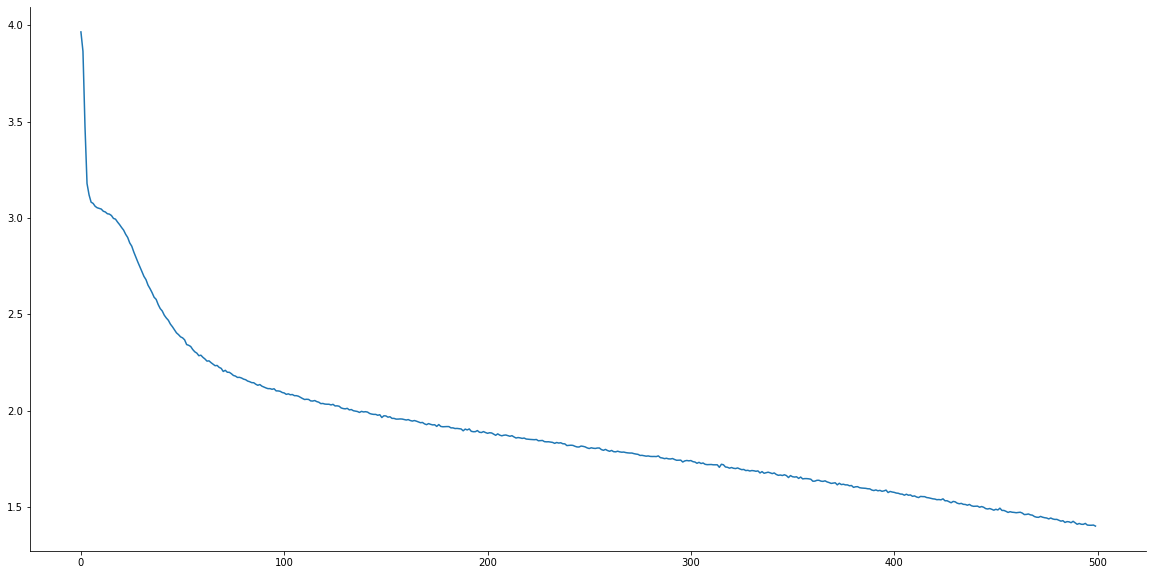

In [16]:
plt.figure(figsize=(20,10))
loss_values = historical_loss.detach().numpy()
seaborn.lineplot(x=range(loss_values.shape[0]), y=loss_values)
seaborn.despine()